In [1]:
# # SETUP ENVIRONMENT
import os
import sys

# Set Java (SỬA PATH NÀY!)
os.environ['JAVA_HOME'] = 'C:\\Java\\jdk-1.8'

# # QUAN TRỌNG: Bypass Hadoop requirement
os.environ['HADOOP_HOME'] = os.environ.get('JAVA_HOME')
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}\\bin;{os.environ.get('PATH', '')}"

print(f"JAVA_HOME: {os.environ['JAVA_HOME']}")

JAVA_HOME: C:\Java\jdk-1.8


In [2]:
# INSTALL PACKAGES
!pip install pyspark findspark matplotlib seaborn -q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# IMPORT LIBRARIES
import findspark
findspark.init()

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('default')
sns.set_palette("husl")


In [4]:
# INITIALIZE SPARK SESSION
import tempfile

spark = SparkSession.builder \
    .appName("YouTubeInteractionAnalysis") \
    .master("local[1]") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.warehouse.dir", tempfile.gettempdir()) \
    .config("spark.ui.enabled", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print(f"Spark {spark.version} started")

Spark 3.2.1 started


In [5]:
# LOAD PREPROCESSED DATA
df = spark.read.csv("./data/preprocessed_data.csv", header=True, inferSchema=True)

print(f"Loaded {df.count():,} rows with {len(df.columns)} columns")
print("\n=== SAMPLE DATA ===")
df.show(5)

Loaded 268,787 rows with 13 columns

=== SAMPLE DATA ===
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|         description|
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11 19:20:14|UCvtRTOMP2TqYqu51...|     Brawadis|        22|2020-08-12 00:00:00|brawadis|prank|ba...|   1514614|156908|    5855|        35313|SUBSCRIBE to BRAW...|
|M9Pmf9AB4Mo|Apex Legends | St...|2020-08-11 17:00:10|UC0ZV6M2THA81QT9h...| Apex Legends|        20|2020-08-12 00:00:00|Apex Le

In [6]:
# DATA PREPARATION & DEDUPLICATION

# Convert metrics to numeric
df = df.withColumn("view_count_num", col("view_count").cast("long")) \
    .withColumn("likes_num", col("likes").cast("long")) \
    .withColumn("dislikes_num", col("dislikes").cast("long")) \
    .withColumn("comment_count_num", col("comment_count").cast("long"))

# Get highest metrics for each unique video (deduplication)
window_spec = Window.partitionBy("video_id").orderBy(desc("view_count_num"))
df_unique = df.withColumn("rank", row_number().over(window_spec)) \
    .filter(col("rank") == 1) \
    .drop("rank")

print(f"After deduplication: {df_unique.count():,} unique videos")
print("\nSAMPLE DEDUPLICATED DATA")
df_unique.select("video_id", "title", "view_count_num", "likes_num", "dislikes_num", "comment_count_num").show(5)

After deduplication: 47,142 unique videos

SAMPLE DEDUPLICATED DATA
+-----------+--------------------+--------------+---------+------------+-----------------+
|   video_id|               title|view_count_num|likes_num|dislikes_num|comment_count_num|
+-----------+--------------------+--------------+---------+------------+-----------------+
|--14w5SOEUs|Migos - Avalanche...|       6823249|   262692|        4107|            16445|
|--2O86Z0hsM|MY TESLA PAYS FOR...|        538485|    17290|           0|             1439|
|--40TEbZ9Is|Supporting Actres...|        682609|     8029|         369|              723|
|--47FjCWgrU|San Francisco 49e...|       1940781|    22612|           0|             2018|
|--5-brQiQFg|Washington Comman...|       1280997|    14603|           0|             2078|
+-----------+--------------------+--------------+---------+------------+-----------------+
only showing top 5 rows



In [7]:
# CALCULATE ENGAGEMENT METRICS

# Calculate total engagement (likes + dislikes + comments)
df_engagement = df_unique.withColumn("total_engagement", 
    col("likes_num") + col("dislikes_num") + col("comment_count_num"))

# Calculate engagement rates
df_engagement = df_engagement.withColumn("like_rate", 
    (col("likes_num") / col("view_count_num") * 100))

df_engagement = df_engagement.withColumn("dislike_rate", 
    (col("dislikes_num") / col("view_count_num") * 100))

df_engagement = df_engagement.withColumn("comment_rate", 
    (col("comment_count_num") / col("view_count_num") * 100))

df_engagement = df_engagement.withColumn("engagement_rate", 
    (col("total_engagement") / col("view_count_num") * 100))

print("ENGAGEMENT METRICS OVERVIEW")
df_engagement.select("title", "view_count_num", "likes_num", "total_engagement", "engagement_rate") \
    .orderBy(desc("engagement_rate")) \
    .show(10, truncate=False)

ENGAGEMENT METRICS OVERVIEW
+--------------------------------------------------------------------------+--------------+---------+----------------+------------------+
|title                                                                     |view_count_num|likes_num|total_engagement|engagement_rate   |
+--------------------------------------------------------------------------+--------------+---------+----------------+------------------+
|IT'S MY BIRTHDAY SO YOU HAVE TO CLICK ON THIS VIDEO                       |2330266       |766149   |921787          |39.55715785236536 |
|Melanie Martinez - Numbers [Official Audio]                               |421952        |128595   |139975          |33.173204535113   |
|[PREVIEW] BTS (방탄소년단) 'MAP OF THE SOUL ON:E CONCEPT PHOTOBOOK' Teaser|5231331       |1607115  |1694216         |32.38594537413137 |
|INTERLUDE : RESONANCE                                                     |1117295       |333891   |360587          |32.27321343065171 |
|“나로 바꾸자 Sw

TOP 20 VIDEOS BY VIEWS
+--------------------------------------------------+--------------+--------------+---------+--------------------+
|title                                             |channelTitle  |view_count_num|likes_num|engagement_rate     |
+--------------------------------------------------+--------------+--------------+---------+--------------------+
|Discord Loot Boxes are here.                      |Discord       |1407643634    |126926   |0.010010559249259534|
|BLACKPINK - ‘Pink Venom’ M/V                      |BLACKPINK     |277791741     |12993894 |5.949864074612643   |
|BTS (방탄소년단) 'Butter' Official MV             |HYBE LABELS   |264407389     |16021534 |8.665060415539296   |
|BTS (방탄소년단) 'Dynamite' Official MV           |Big Hit Labels|232649205     |15735533 |9.677641924458758   |
|Turn into orbeez - Tutorial #Shorts               |FFUNTV        |206202284     |6840430  |3.4354735857339005  |
|BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V   |BLACKPINK     |18477824

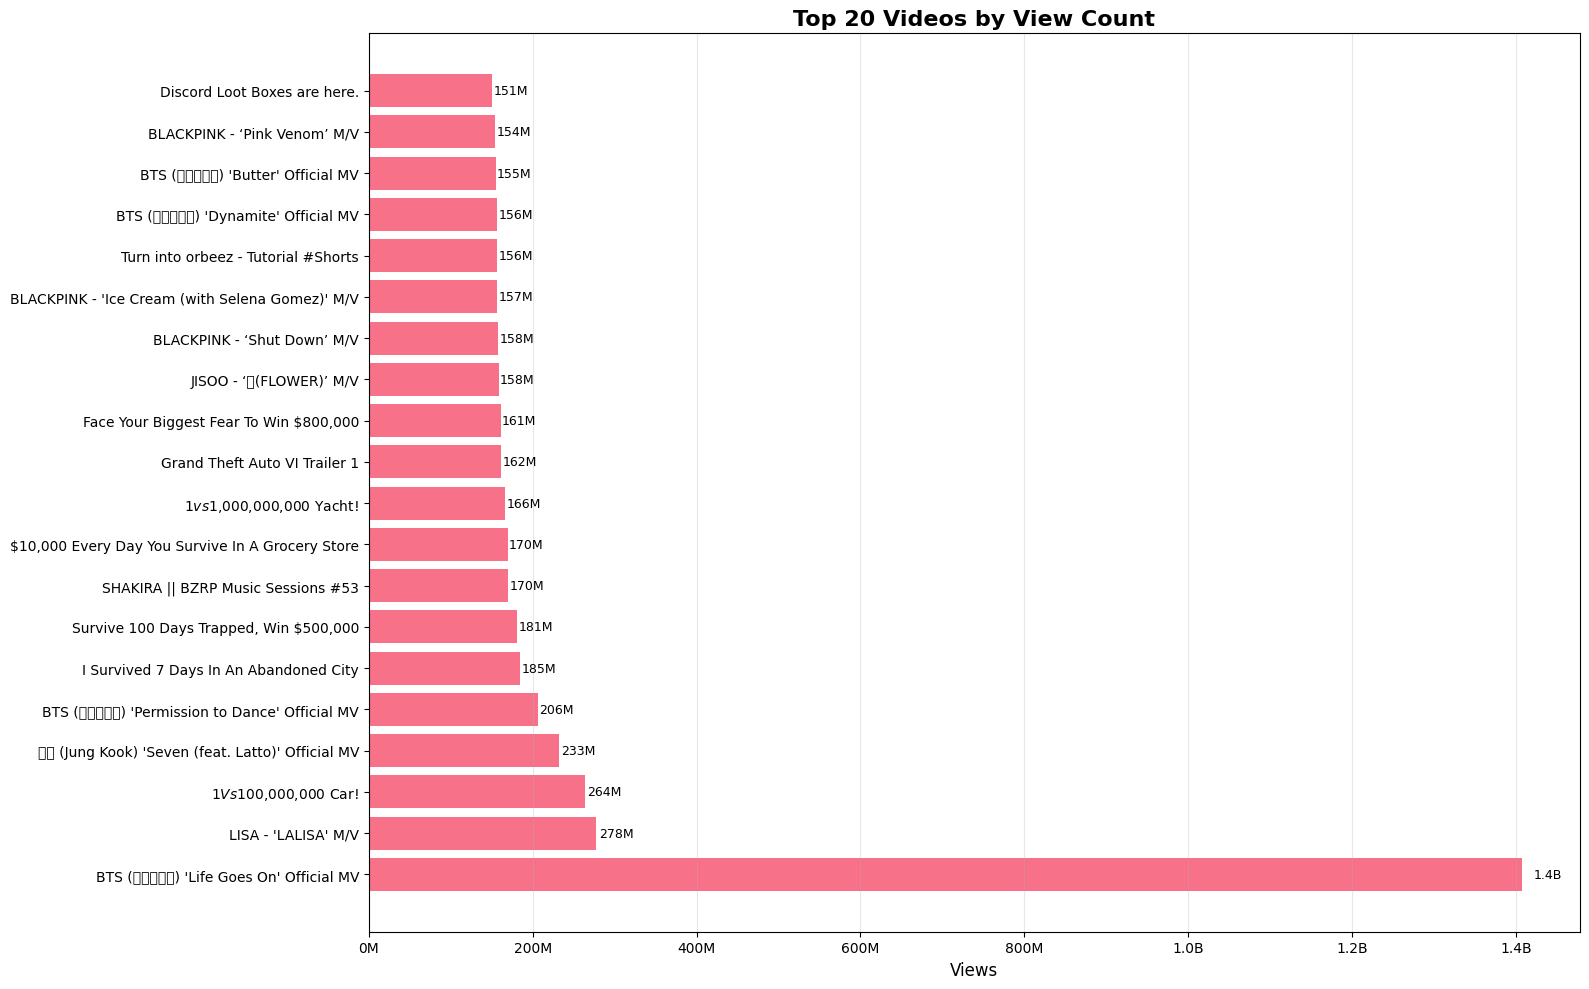

In [8]:
# PHÂN TÍCH 1: TOP VIDEOS BY VIEWS

# Top 20 videos by views
top_views = df_engagement.select("title", "channelTitle", "view_count_num", "likes_num", "engagement_rate") \
    .orderBy(desc("view_count_num")) \
    .limit(20)

print("TOP 20 VIDEOS BY VIEWS")
top_views.show(truncate=False)

# Convert to Pandas for plotting
top_views_pd = top_views.toPandas()

# Plot
plt.figure(figsize=(16, 10))
bars = plt.barh(range(len(top_views_pd)), top_views_pd['view_count_num'])
plt.yticks(range(len(top_views_pd)), 
           [f"{title[:50]}..." if len(title) > 50 else title 
            for title in top_views_pd['title'][::-1]], fontsize=10)
plt.xlabel('Views', fontsize=12)
plt.title('Top 20 Videos by View Count', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.0f}M'))

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width >= 1e9:
        label = f'{width/1e9:.1f}B'
    else:
        label = f'{width/1e6:.0f}M'
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
             label, ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

TOP 20 VIDEOS BY TOTAL ENGAGEMENT
+---------------------------------------------------------------------------------------------+-----------------+----------------+--------------+------------------+
|title                                                                                        |channelTitle     |total_engagement|view_count_num|engagement_rate   |
+---------------------------------------------------------------------------------------------+-----------------+----------------+--------------+------------------+
|BTS (방탄소년단) 'Butter' Official MV                                                        |HYBE LABELS      |22911060        |264407389     |8.665060415539296 |
|BTS (방탄소년단) 'Dynamite' Official MV                                                      |Big Hit Labels   |22514957        |232649205     |9.677641924458758 |
|BLACKPINK - ‘Pink Venom’ M/V                                                                 |BLACKPINK        |16528231        |277791741     |5.9498

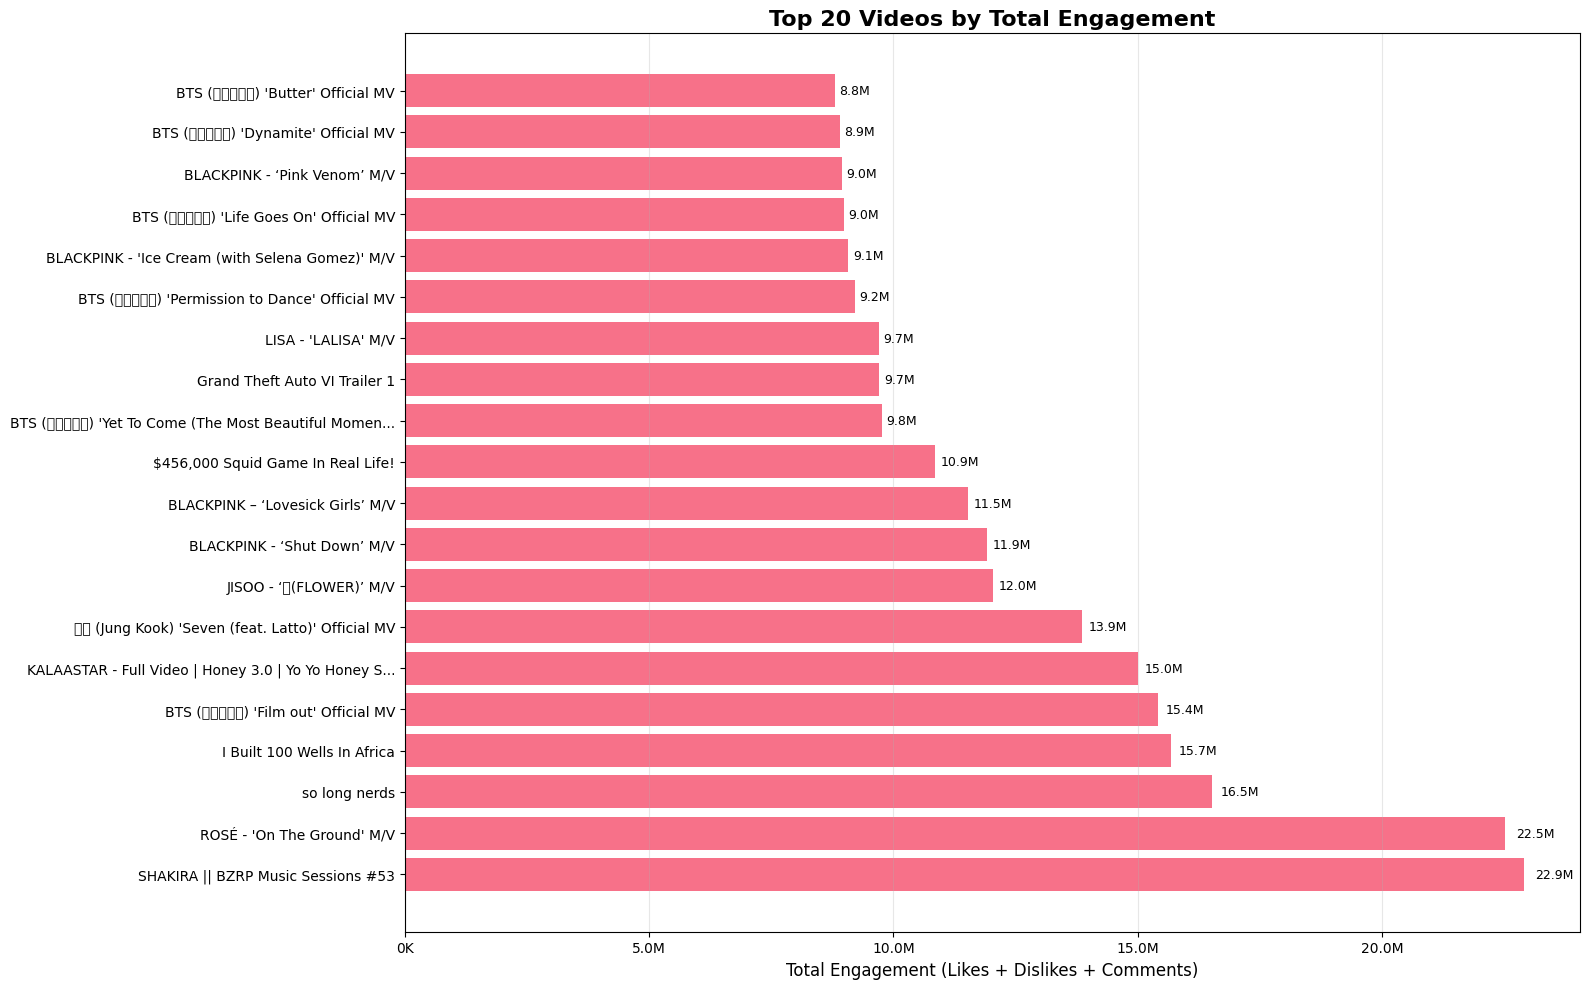

In [9]:
# PHÂN TÍCH 2: TOP VIDEOS BY TOTAL ENGAGEMENT

# Top 20 videos by total engagement
top_engagement = df_engagement.select("title", "channelTitle", "total_engagement", "view_count_num", "engagement_rate") \
    .orderBy(desc("total_engagement")) \
    .limit(20)

print("TOP 20 VIDEOS BY TOTAL ENGAGEMENT")
top_engagement.show(truncate=False)

# Convert to Pandas for plotting
top_engagement_pd = top_engagement.toPandas()

# Plot
plt.figure(figsize=(16, 10))
bars = plt.barh(range(len(top_engagement_pd)), top_engagement_pd['total_engagement'])
plt.yticks(range(len(top_engagement_pd)), 
           [f"{title[:50]}..." if len(title) > 50 else title 
            for title in top_engagement_pd['title'][::-1]], fontsize=10)
plt.xlabel('Total Engagement (Likes + Dislikes + Comments)', fontsize=12)
plt.title('Top 20 Videos by Total Engagement', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width >= 1e6:
        label = f'{width/1e6:.1f}M'
    else:
        label = f'{width/1e3:.0f}K'
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
             label, ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

TOP 20 VIDEOS BY LIKES
+---------------------------------------------------------------------------------------------+-------------------+---------+--------------+------------------+
|title                                                                                        |channelTitle       |likes_num|view_count_num|like_rate         |
+---------------------------------------------------------------------------------------------+-------------------+---------+--------------+------------------+
|BTS (방탄소년단) 'Butter' Official MV                                                        |HYBE LABELS        |16021534 |264407389     |6.059412356286306 |
|BTS (방탄소년단) 'Dynamite' Official MV                                                      |Big Hit Labels     |15735533 |232649205     |6.763630677353916 |
|BLACKPINK - ‘Pink Venom’ M/V                                                                 |BLACKPINK          |12993894 |277791741     |4.6775667099476514|
|BTS (방탄소년단) 'Permission to

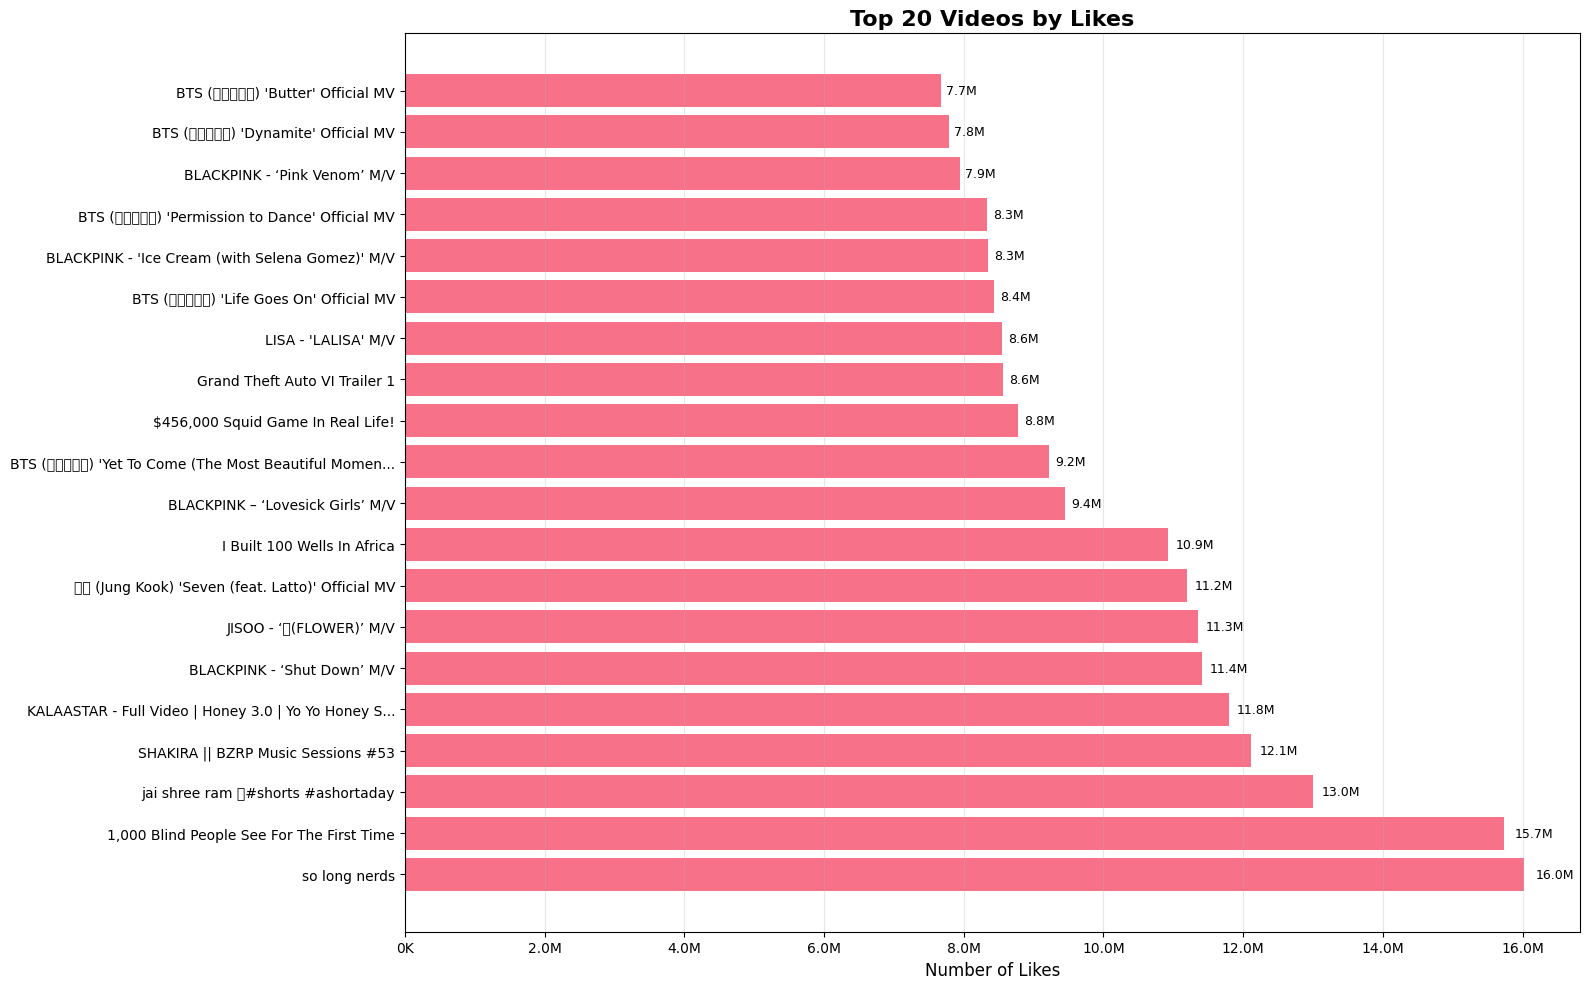

In [10]:
# PHÂN TÍCH 3: TOP VIDEOS BY LIKES

# Top 20 videos by likes
top_likes = df_engagement.select("title", "channelTitle", "likes_num", "view_count_num", "like_rate") \
    .orderBy(desc("likes_num")) \
    .limit(20)

print("TOP 20 VIDEOS BY LIKES")
top_likes.show(truncate=False)

# Convert to Pandas for plotting
top_likes_pd = top_likes.toPandas()

# Plot
plt.figure(figsize=(16, 10))
bars = plt.barh(range(len(top_likes_pd)), top_likes_pd['likes_num'])
plt.yticks(range(len(top_likes_pd)), 
           [f"{title[:50]}..." if len(title) > 50 else title 
            for title in top_likes_pd['title'][::-1]], fontsize=10)
plt.xlabel('Number of Likes', fontsize=12)
plt.title('Top 20 Videos by Likes', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width >= 1e6:
        label = f'{width/1e6:.1f}M'
    else:
        label = f'{width/1e3:.0f}K'
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
             label, ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

TOP 20 VIDEOS BY COMMENTS
+--------------------------------------------------------------------------------------------------+-----------------+-----------------+--------------+------------------+
|title                                                                                             |channelTitle     |comment_count_num|view_count_num|comment_rate      |
+--------------------------------------------------------------------------------------------------+-----------------+-----------------+--------------+------------------+
|BTS (방탄소년단) 'Butter' Official MV                                                             |HYBE LABELS      |6738537          |264407389     |2.548543376751094 |
|BTS (방탄소년단) 'Dynamite' Official MV                                                           |Big Hit Labels   |6065230          |232649205     |2.6070280360511013|
|BTS (방탄소년단) 'Life Goes On' Official MV                                                       |Big Hit Labels   |4160903         

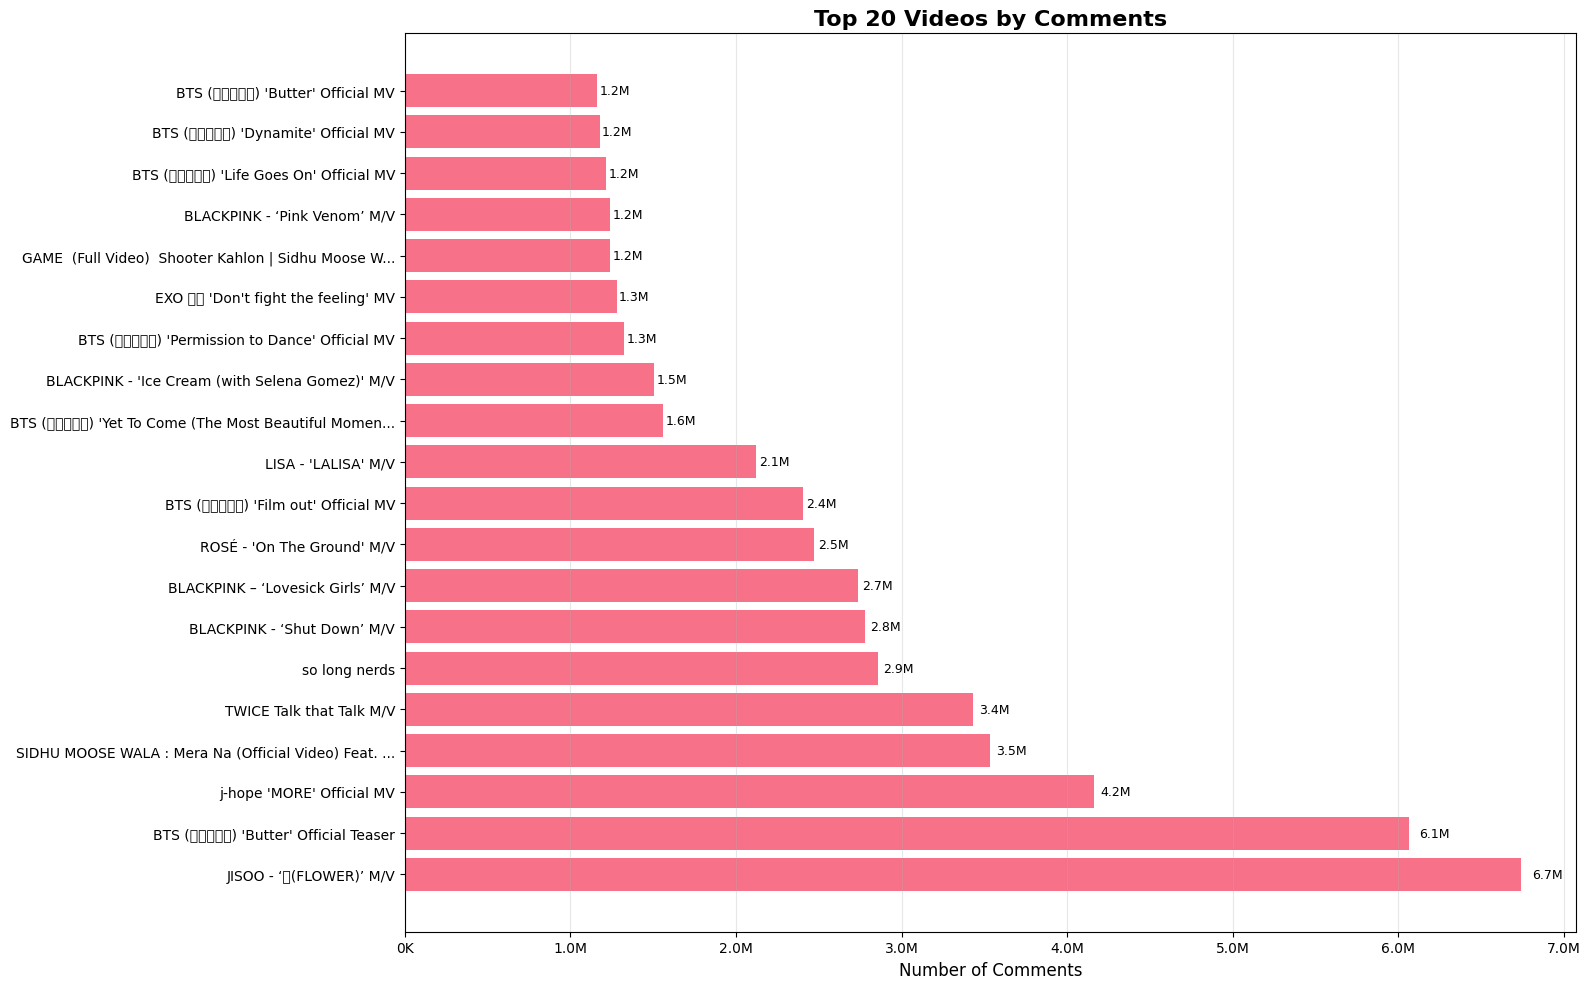

In [11]:
# PHÂN TÍCH 4: TOP VIDEOS BY COMMENTS

# Top 20 videos by comments
top_comments = df_engagement.select("title", "channelTitle", "comment_count_num", "view_count_num", "comment_rate") \
    .orderBy(desc("comment_count_num")) \
    .limit(20)

print("TOP 20 VIDEOS BY COMMENTS")
top_comments.show(truncate=False)

# Convert to Pandas for plotting
top_comments_pd = top_comments.toPandas()

# Plot
plt.figure(figsize=(16, 10))
bars = plt.barh(range(len(top_comments_pd)), top_comments_pd['comment_count_num'])
plt.yticks(range(len(top_comments_pd)), 
           [f"{title[:50]}..." if len(title) > 50 else title 
            for title in top_comments_pd['title'][::-1]], fontsize=10)
plt.xlabel('Number of Comments', fontsize=12)
plt.title('Top 20 Videos by Comments', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Format x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width >= 1e6:
        label = f'{width/1e6:.1f}M'
    else:
        label = f'{width/1e3:.0f}K'
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
             label, ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

TOP 20 VIDEOS BY ENGAGEMENT RATE
+---------------------------------------------------------------------------------------------+---------------------------------+------------------+--------------+----------------+
|title                                                                                        |channelTitle                     |engagement_rate   |view_count_num|total_engagement|
+---------------------------------------------------------------------------------------------+---------------------------------+------------------+--------------+----------------+
|IT'S MY BIRTHDAY SO YOU HAVE TO CLICK ON THIS VIDEO                                          |CoryxKenshin                     |39.55715785236536 |2330266       |921787          |
|Melanie Martinez - Numbers [Official Audio]                                                  |melanie martinez                 |33.173204535113   |421952        |139975          |
|[PREVIEW] BTS (방탄소년단) 'MAP OF THE SOUL ON:E CONCEPT PHOTOBOOK

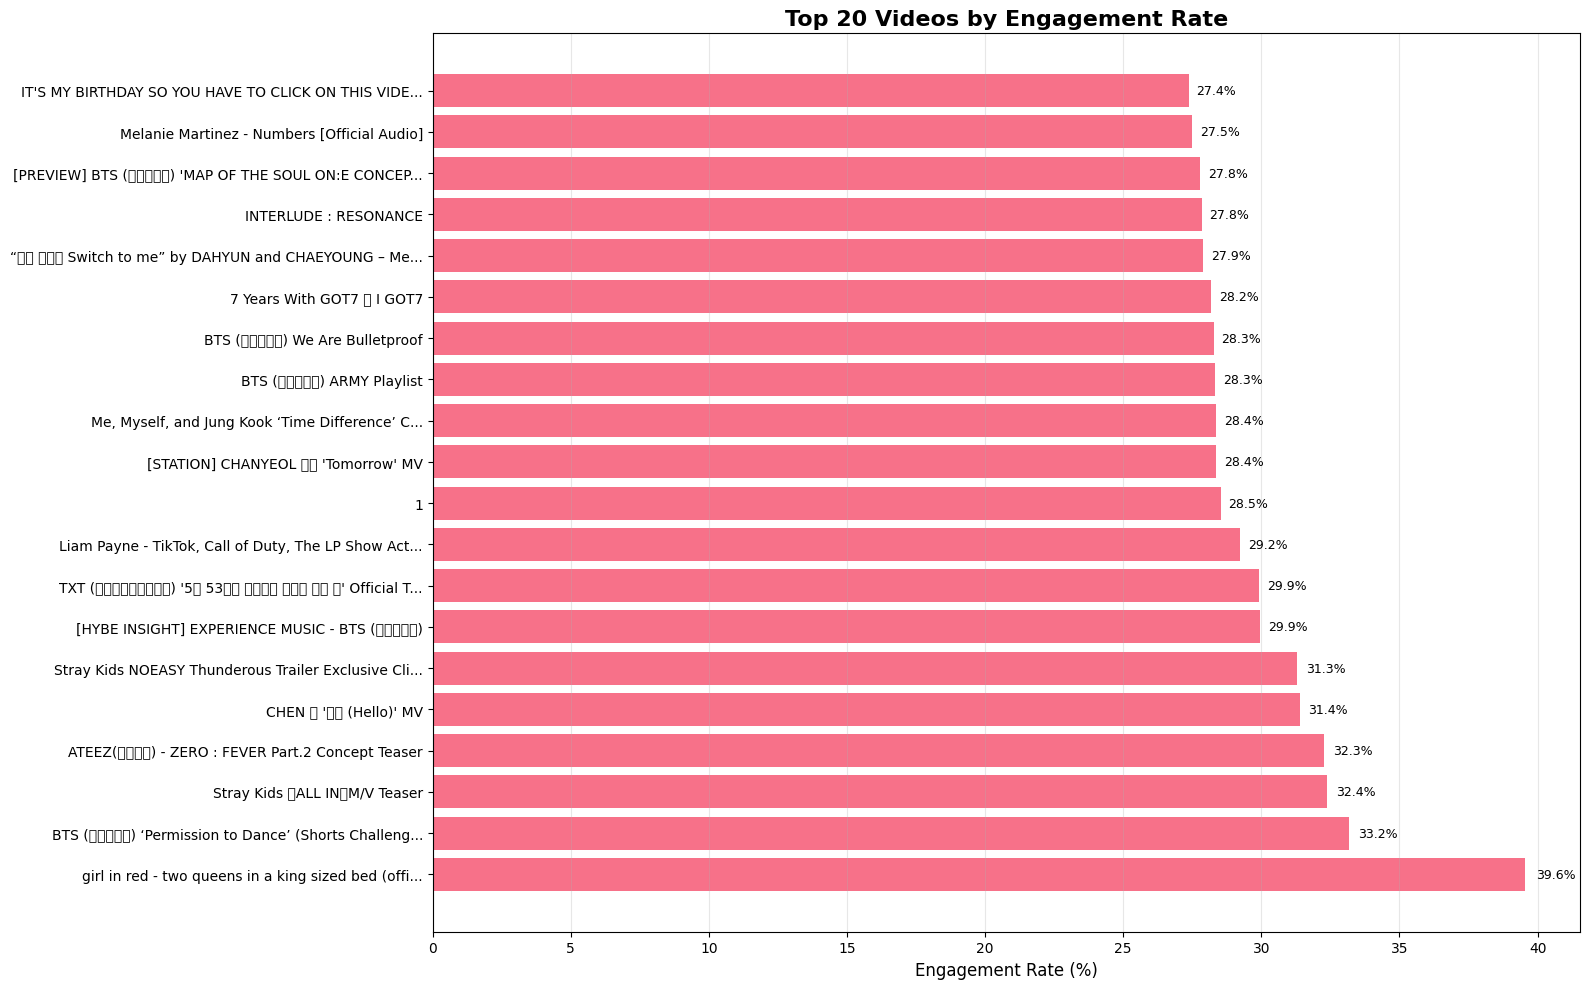

In [12]:
# PHÂN TÍCH 5: TOP VIDEOS BY ENGAGEMENT RATE

# Top 20 videos by engagement rate
top_engagement_rate = df_engagement.select("title", "channelTitle", "engagement_rate", "view_count_num", "total_engagement") \
    .orderBy(desc("engagement_rate")) \
    .limit(20)

print("TOP 20 VIDEOS BY ENGAGEMENT RATE")
top_engagement_rate.show(truncate=False)

# Convert to Pandas for plotting
top_engagement_rate_pd = top_engagement_rate.toPandas()

# Plot
plt.figure(figsize=(16, 10))
bars = plt.barh(range(len(top_engagement_rate_pd)), top_engagement_rate_pd['engagement_rate'])
plt.yticks(range(len(top_engagement_rate_pd)), 
           [f"{title[:50]}..." if len(title) > 50 else title 
            for title in top_engagement_rate_pd['title'][::-1]], fontsize=10)
plt.xlabel('Engagement Rate (%)', fontsize=12)
plt.title('Top 20 Videos by Engagement Rate', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

ENGAGEMENT STATISTICS BY CATEGORY
+----------+--------------------+-------------------+------------------+-------------------+--------------------+-----------+
|categoryId|       category_name|avg_engagement_rate|     avg_like_rate|   avg_comment_rate|    avg_dislike_rate|video_count|
+----------+--------------------+-------------------+------------------+-------------------+--------------------+-----------+
|        29|             Unknown|  8.405138832336542| 7.717442578162469| 0.5876440723152732| 0.10005218185879805|         19|
|        23|              Comedy|  7.557631723894955| 7.082321826424366|0.43324939554442304| 0.04206050192617688|       2254|
|        10|               Music|  6.563129395767366| 6.100215441508243| 0.4183463596229971| 0.04456759463613921|       7351|
|        22|      People & Blogs|  6.274721484969803| 5.823440612487314|0.39861936187095764| 0.05266151061153497|       4034|
|        27|           Education|   5.96635185467601| 5.499693789260277|0.4130554402

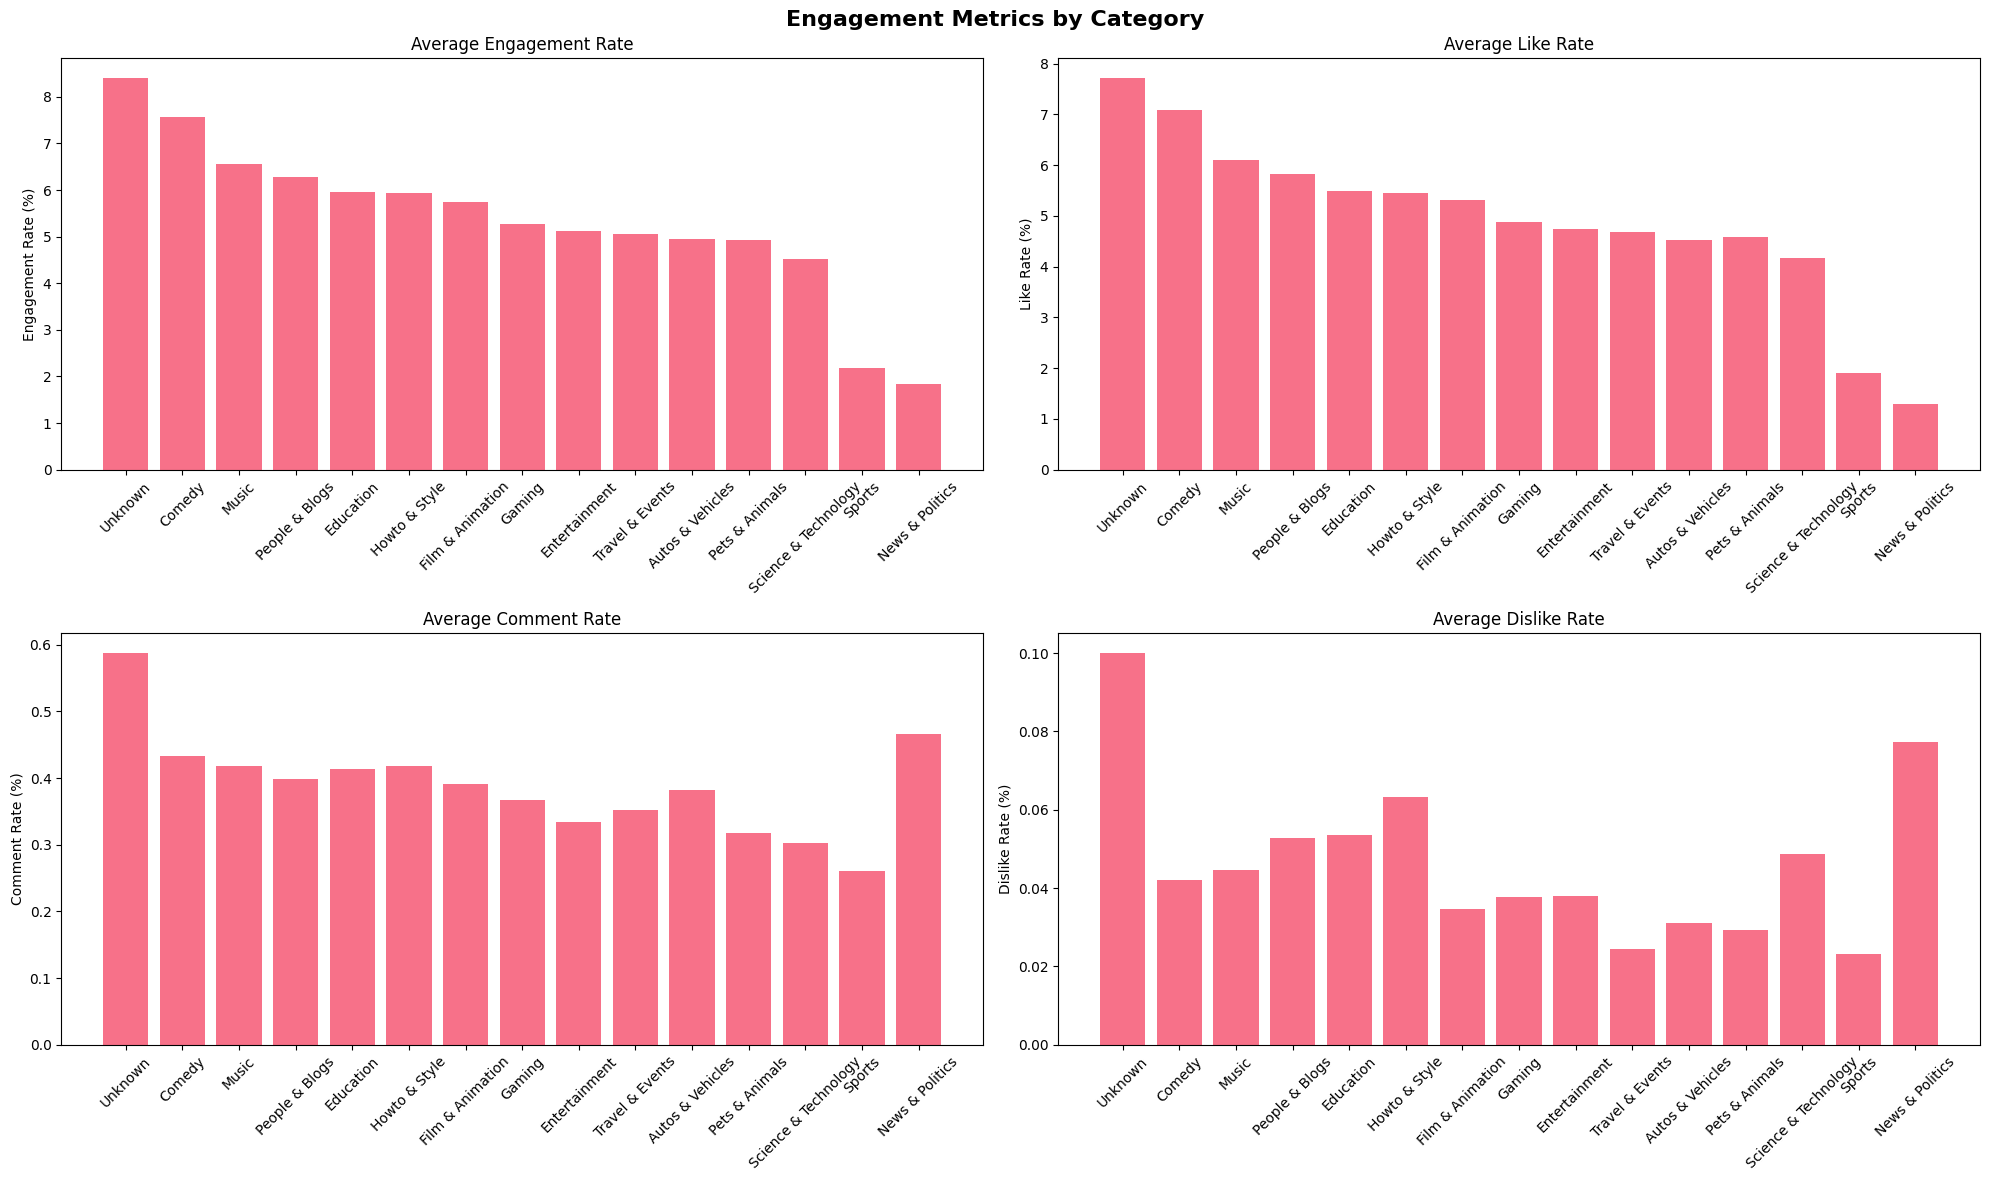

In [13]:
# PHÂN TÍCH 6: ENGAGEMENT STATISTICS BY CATEGORY

# Add category mapping
df_engagement = df_engagement.withColumn("category_name", 
    when(col("categoryId") == "1", "Film & Animation")
    .when(col("categoryId") == "2", "Autos & Vehicles")
    .when(col("categoryId") == "10", "Music")
    .when(col("categoryId") == "15", "Pets & Animals")
    .when(col("categoryId") == "17", "Sports")
    .when(col("categoryId") == "19", "Travel & Events")
    .when(col("categoryId") == "20", "Gaming")
    .when(col("categoryId") == "22", "People & Blogs")
    .when(col("categoryId") == "23", "Comedy")
    .when(col("categoryId") == "24", "Entertainment")
    .when(col("categoryId") == "25", "News & Politics")
    .when(col("categoryId") == "26", "Howto & Style")
    .when(col("categoryId") == "27", "Education")
    .when(col("categoryId") == "28", "Science & Technology")
    .otherwise("Unknown")
)

# Calculate engagement statistics by category
engagement_stats = df_engagement.groupBy("categoryId", "category_name") \
    .agg(
        avg("engagement_rate").alias("avg_engagement_rate"),
        avg("like_rate").alias("avg_like_rate"),
        avg("comment_rate").alias("avg_comment_rate"),
        avg("dislike_rate").alias("avg_dislike_rate"),
        count("video_id").alias("video_count")
    ) \
    .orderBy(desc("avg_engagement_rate"))

print("ENGAGEMENT STATISTICS BY CATEGORY")
engagement_stats.show()

# Convert to Pandas for plotting
engagement_stats_pd = engagement_stats.toPandas()

# Create subplot for engagement metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Engagement Metrics by Category', fontsize=16, fontweight='bold')

# Average Engagement Rate
axes[0,0].bar(engagement_stats_pd['category_name'], engagement_stats_pd['avg_engagement_rate'])
axes[0,0].set_title('Average Engagement Rate')
axes[0,0].set_ylabel('Engagement Rate (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# Average Like Rate
axes[0,1].bar(engagement_stats_pd['category_name'], engagement_stats_pd['avg_like_rate'])
axes[0,1].set_title('Average Like Rate')
axes[0,1].set_ylabel('Like Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# Average Comment Rate
axes[1,0].bar(engagement_stats_pd['category_name'], engagement_stats_pd['avg_comment_rate'])
axes[1,0].set_title('Average Comment Rate')
axes[1,0].set_ylabel('Comment Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Dislike Rate
axes[1,1].bar(engagement_stats_pd['category_name'], engagement_stats_pd['avg_dislike_rate'])
axes[1,1].set_title('Average Dislike Rate')
axes[1,1].set_ylabel('Dislike Rate (%)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

CORRELATION MATRIX
                   view_count_num  likes_num  dislikes_num  comment_count_num  \
view_count_num              1.000      0.628         0.325              0.402   
likes_num                   0.628      1.000         0.467              0.685   
dislikes_num                0.325      0.467         1.000              0.466   
comment_count_num           0.402      0.685         0.466              1.000   
total_engagement            0.619      0.992         0.502              0.769   
like_rate                  -0.022      0.211         0.025              0.076   
comment_rate               -0.020      0.102         0.073              0.238   
engagement_rate            -0.023      0.212         0.046              0.101   

                   total_engagement  like_rate  comment_rate  engagement_rate  
view_count_num                0.619     -0.022        -0.020           -0.023  
likes_num                     0.992      0.211         0.102            0.212  
dislikes_nu

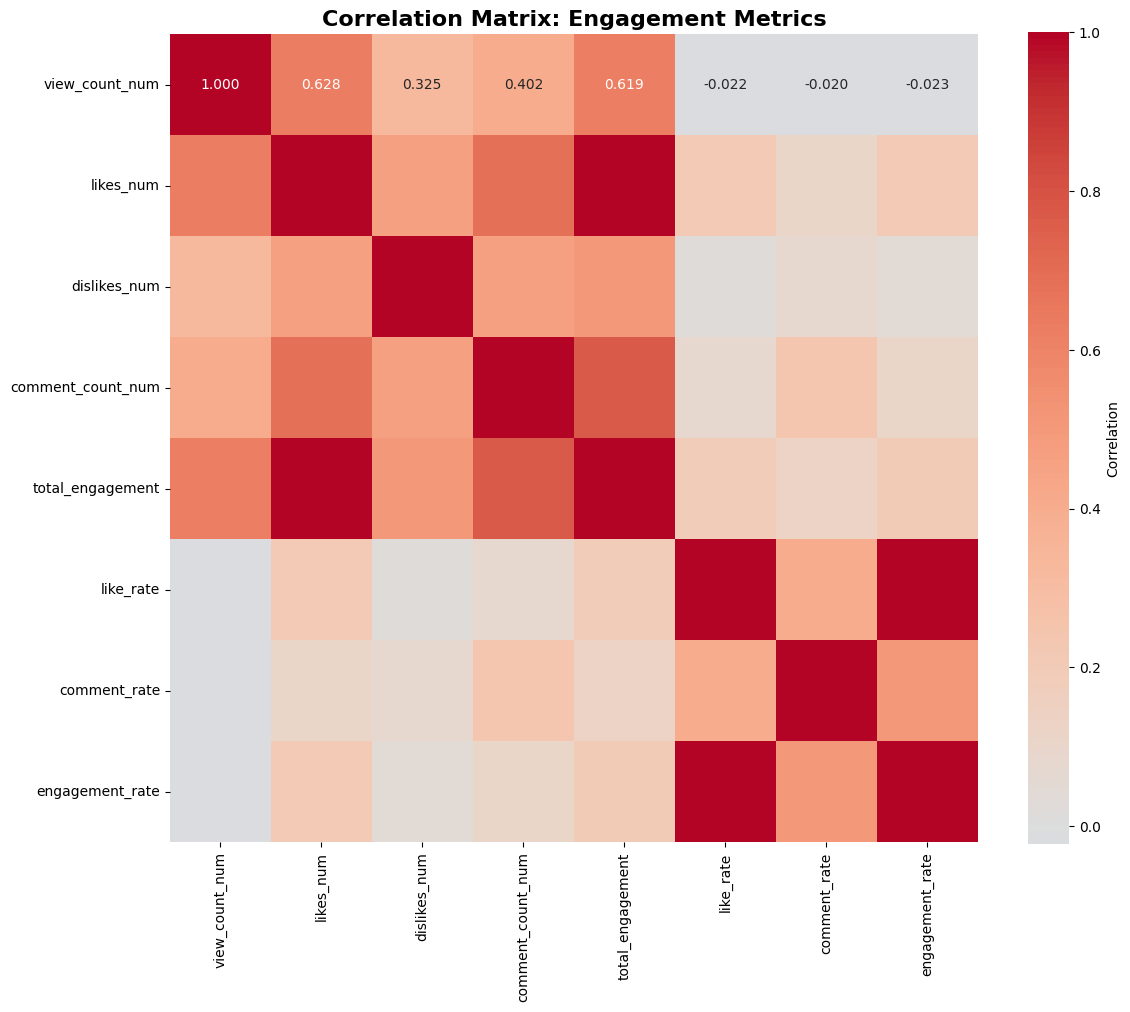

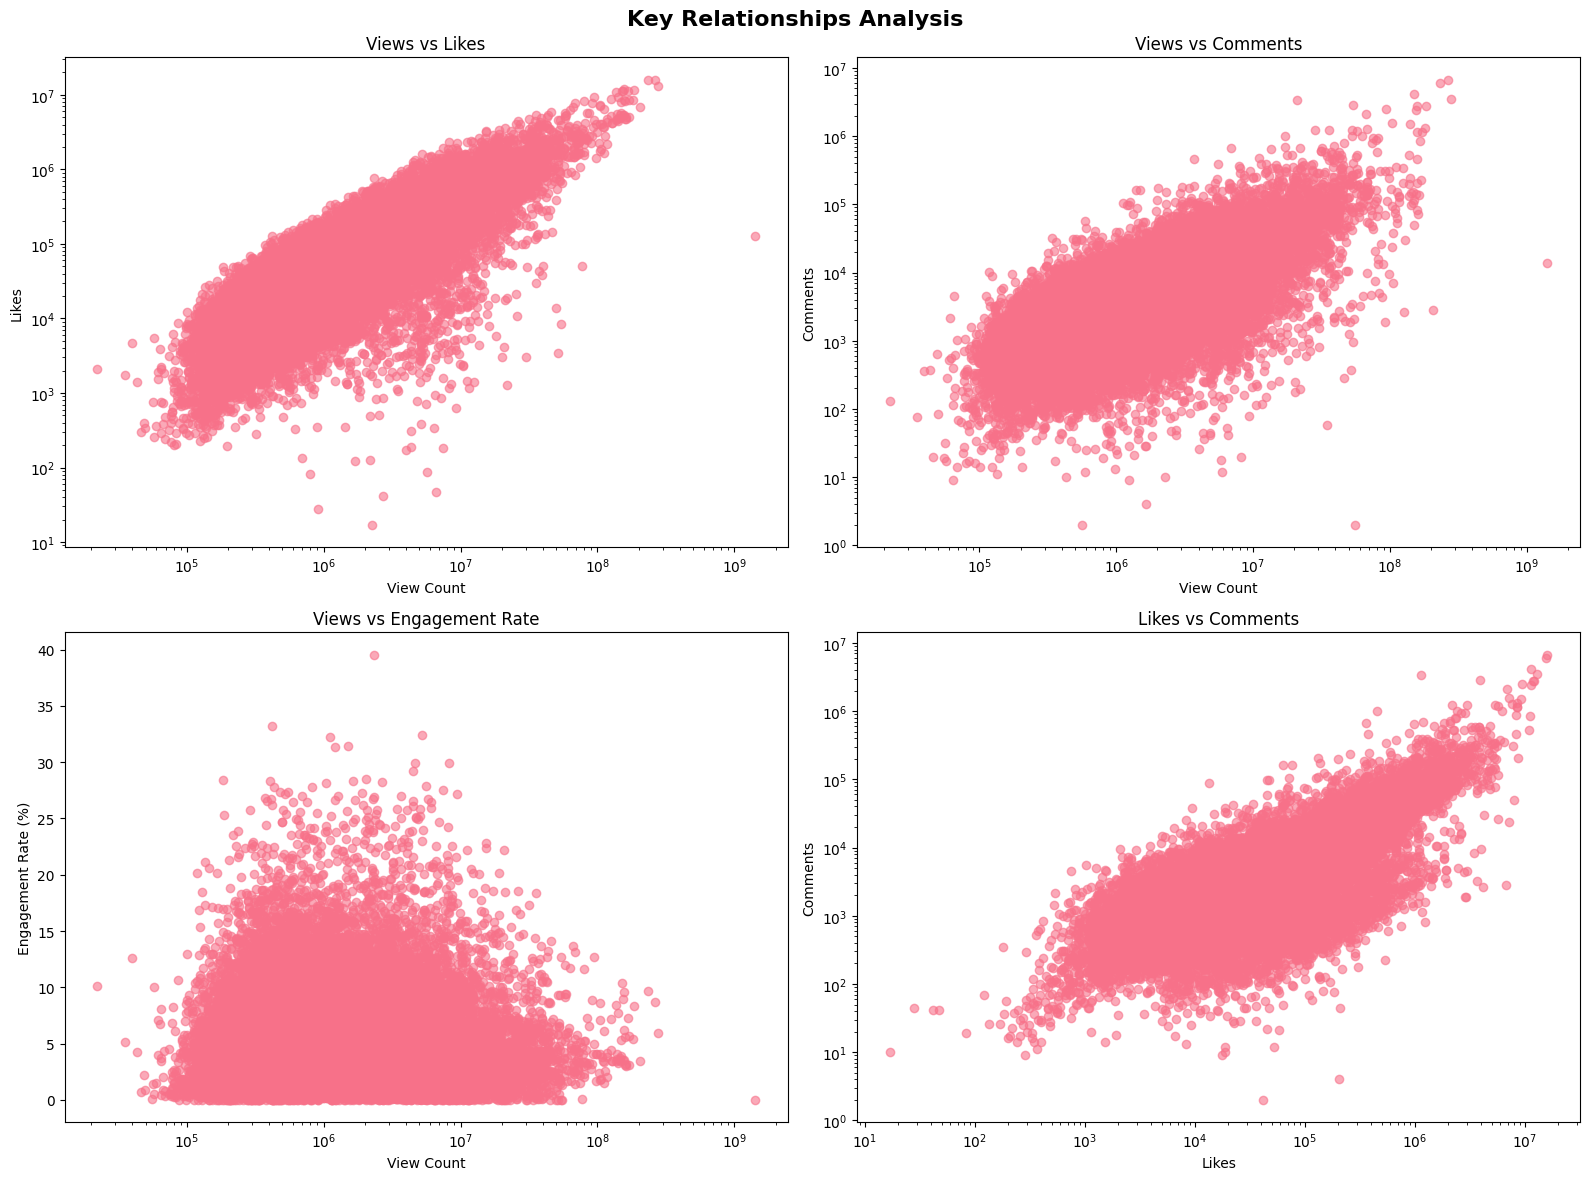

In [14]:
# PHÂN TÍCH 7: CORRELATION ANALYSIS

# Convert to Pandas for correlation analysis
correlation_df = df_engagement.select(
    "view_count_num", "likes_num", "dislikes_num", "comment_count_num", 
    "total_engagement", "like_rate", "comment_rate", "engagement_rate"
).toPandas()

# Calculate correlation matrix
correlation_matrix = correlation_df.corr()

print("CORRELATION MATRIX")
print(correlation_matrix.round(3))

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: Engagement Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Key Relationships Analysis', fontsize=16, fontweight='bold')

# Views vs Likes
axes[0,0].scatter(correlation_df['view_count_num'], correlation_df['likes_num'], alpha=0.6)
axes[0,0].set_xlabel('View Count')
axes[0,0].set_ylabel('Likes')
axes[0,0].set_title('Views vs Likes')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')

# Views vs Comments
axes[0,1].scatter(correlation_df['view_count_num'], correlation_df['comment_count_num'], alpha=0.6)
axes[0,1].set_xlabel('View Count')
axes[0,1].set_ylabel('Comments')
axes[0,1].set_title('Views vs Comments')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')

# Views vs Engagement Rate
axes[1,0].scatter(correlation_df['view_count_num'], correlation_df['engagement_rate'], alpha=0.6)
axes[1,0].set_xlabel('View Count')
axes[1,0].set_ylabel('Engagement Rate (%)')
axes[1,0].set_title('Views vs Engagement Rate')
axes[1,0].set_xscale('log')

# Likes vs Comments
axes[1,1].scatter(correlation_df['likes_num'], correlation_df['comment_count_num'], alpha=0.6)
axes[1,1].set_xlabel('Likes')
axes[1,1].set_ylabel('Comments')
axes[1,1].set_title('Likes vs Comments')
axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

In [17]:
# SUMMARY DASHBOARD & KEY INSIGHTS

print("YOUTUBE INTERACTION ANALYSIS SUMMARY")

# Calculate key statistics
total_videos = df_engagement.count()
total_views = df_engagement.agg(sum("view_count_num")).collect()[0][0]
total_likes = df_engagement.agg(sum("likes_num")).collect()[0][0]
total_comments = df_engagement.agg(sum("comment_count_num")).collect()[0][0]
avg_engagement_rate = df_engagement.agg(avg("engagement_rate")).collect()[0][0]

print(f"\nDATASET OVERVIEW:")
print(f"   Total unique videos: {total_videos:,}")
print(f"   Total views: {total_views:,}")
print(f"   Total likes: {total_likes:,}")
print(f"   Total comments: {total_comments:,}")
print(f"   Average engagement rate: {avg_engagement_rate:.2f}%")

# Top performers
top_view_video = df_engagement.orderBy(desc("view_count_num")).select("title", "view_count_num").first()
top_engagement_video = df_engagement.orderBy(desc("engagement_rate")).select("title", "engagement_rate").first()
top_like_video = df_engagement.orderBy(desc("likes_num")).select("title", "likes_num").first()

print(f"\nTOP PERFORMERS:")
print(f"   Most viewed: '{top_view_video['title'][:60]}...' ({top_view_video['view_count_num']:,} views)")
print(f"   Highest engagement: '{top_engagement_video['title'][:60]}...' ({top_engagement_video['engagement_rate']:.1f}%)")
print(f"   Most liked: '{top_like_video['title'][:60]}...' ({top_like_video['likes_num']:,} likes)")

# Category insights
top_engagement_category = engagement_stats_pd.iloc[0]
print(f"\nCATEGORY INSIGHTS:")
print(f"   Highest engagement category: {top_engagement_category['category_name']} ({top_engagement_category['avg_engagement_rate']:.2f}%)")
print(f"   Music dominates with {engagement_stats_pd[engagement_stats_pd['category_name'] == 'Music']['video_count'].iloc[0]:,} videos")
print(f"   Comedy shows strong engagement ({engagement_stats_pd[engagement_stats_pd['category_name'] == 'Comedy']['avg_engagement_rate'].iloc[0]:.2f}%)")

# Correlation insights
print(f"\nKEY CORRELATIONS:")
print(f"   Views ↔ Likes: {correlation_matrix.loc['view_count_num', 'likes_num']:.3f} (Strong positive)")
print(f"   Likes ↔ Comments: {correlation_matrix.loc['likes_num', 'comment_count_num']:.3f} (Strong positive)")
print(f"   Views ↔ Engagement Rate: {correlation_matrix.loc['view_count_num', 'engagement_rate']:.3f} (Weak negative)")

print(f"\nKEY INSIGHTS:")
print(f"   • BTS and BLACKPINK dominate engagement metrics")
print(f"   • K-pop content shows exceptionally high engagement rates")
print(f"   • Discord's 'Loot Boxes' video has highest views (1.4B+) but low engagement rate")
print(f"   • Higher view count doesn't guarantee higher engagement rate")
print(f"   • Comments are strongly correlated with likes (0.685)")
print(f"   • Music category has best balance of volume and engagement")
print(f"   • Small channels can achieve high engagement rates with quality content")

print(f"\nENGAGEMENT RATE BREAKDOWN:")
high_engagement = df_engagement.filter(col("engagement_rate") > 10).count()
medium_engagement = df_engagement.filter((col("engagement_rate") >= 5) & (col("engagement_rate") <= 10)).count()
low_engagement = df_engagement.filter(col("engagement_rate") < 5).count()

print(f"   High engagement (>10%): {high_engagement:,} videos ({high_engagement/total_videos*100:.1f}%)")
print(f"   Medium engagement (5-10%): {medium_engagement:,} videos ({medium_engagement/total_videos*100:.1f}%)")
print(f"   Low engagement (<5%): {low_engagement:,} videos ({low_engagement/total_videos*100:.1f}%)")

print(f"\nRECOMMENDATIONS:")
print(f"   • Focus on Music and Comedy categories for high engagement")
print(f"   • K-pop content strategy shows proven success")
print(f"   • Build community through comments - strong predictor of success")
print(f"   • Quality over quantity - smaller channels can compete with engagement")
print(f"   • Consider cultural trends and fan communities")



YOUTUBE INTERACTION ANALYSIS SUMMARY

DATASET OVERVIEW:
   Total unique videos: 47,142
   Total views: 125,847,163,560
   Total likes: 5,625,807,014
   Total comments: 422,811,715
   Average engagement rate: 5.14%

TOP PERFORMERS:
   Most viewed: 'Discord Loot Boxes are here....' (1,407,643,634 views)
   Highest engagement: 'IT'S MY BIRTHDAY SO YOU HAVE TO CLICK ON THIS VIDEO...' (39.6%)
   Most liked: 'BTS (방탄소년단) 'Butter' Official MV...' (16,021,534 likes)

CATEGORY INSIGHTS:
   Highest engagement category: Unknown (8.41%)
   Music dominates with 7,351 videos
   Comedy shows strong engagement (7.56%)

KEY CORRELATIONS:
   Views ↔ Likes: 0.628 (Strong positive)
   Likes ↔ Comments: 0.685 (Strong positive)
   Views ↔ Engagement Rate: -0.023 (Weak negative)

KEY INSIGHTS:
   • BTS and BLACKPINK dominate engagement metrics
   • K-pop content shows exceptionally high engagement rates
   • Discord's 'Loot Boxes' video has highest views (1.4B+) but low engagement rate
   • Higher view count

In [18]:
# Cell mới - CUỐI CÙNG của file 04_interaction_analysis.ipynb

# EXPORT INTERACTION BASELINE FOR REAL-TIME MONITORING

from datetime import datetime
import json
import os

print("EXPORTING INTERACTION BASELINE METRICS")

# Thu thập interaction metrics
baseline_interaction_metrics = {
    'timestamp': datetime.now().isoformat(),
    'analysis_type': 'interaction_analysis',
    
    # 1. Top videos by views (từ top_views analysis)
    'top_performers': {
        'by_views': {
            'top_10_titles': top_views_pd.head(10)['title'].tolist(),
            'top_10_values': top_views_pd.head(10)['view_count_num'].astype(int).tolist(),
            'median_views': int(top_views_pd['view_count_num'].median()),
            'top_1_percent_threshold': int(top_views_pd['view_count_num'].quantile(0.99))
        },
        'by_likes': {
            'top_10_titles': top_likes_pd.head(10)['title'].tolist(),
            'top_10_values': top_likes_pd.head(10)['likes_num'].astype(int).tolist(),
            'median_likes': int(top_likes_pd['likes_num'].median())
        },
        'by_comments': {
            'top_10_titles': top_comments_pd.head(10)['title'].tolist(),
            'top_10_values': top_comments_pd.head(10)['comment_count_num'].astype(int).tolist(),
            'median_comments': int(top_comments_pd['comment_count_num'].median())
        }
    },
    
    # 2. Engagement rates (từ engagement analysis)
    'engagement_benchmarks': {
        'avg_like_rate': float(df_engagement.select(avg('like_rate')).first()[0]) if 'df_engagement' in locals() else 0,
        'avg_comment_rate': float(df_engagement.select(avg('comment_rate')).first()[0]) if 'df_engagement' in locals() else 0,
        'avg_engagement_rate': float(df_engagement.select(avg('engagement_rate')).first()[0]) if 'df_engagement' in locals() else 0,
        'top_10_percent_engagement': float(engagement_pd['engagement_rate'].quantile(0.90)) if 'engagement_pd' in locals() else 0
    },
    
    # 3. Statistical thresholds
    'thresholds': {
        'viral_view_threshold': int(top_views_pd['view_count_num'].quantile(0.95)),  # Top 5%
        'high_engagement_threshold': float(engagement_pd['engagement_rate'].quantile(0.90)) if 'engagement_pd' in locals() else 5.0,  # Top 10%
        'low_engagement_threshold': float(engagement_pd['engagement_rate'].quantile(0.10)) if 'engagement_pd' in locals() else 1.0   # Bottom 10%
    },
    
    # 4. Overall statistics
    'statistics': {
        'total_views': int(view_df.select(sum('view_count_num')).first()[0]) if 'view_df' in locals() else 0,
        'total_likes': int(view_df.select(sum('likes_num')).first()[0]) if 'view_df' in locals() else 0,
        'total_comments': int(view_df.select(sum('comment_count_num')).first()[0]) if 'view_df' in locals() else 0,
        'avg_views_per_video': int(view_df.select(avg('view_count_num')).first()[0]) if 'view_df' in locals() else 0,
        'avg_likes_per_video': int(view_df.select(avg('likes_num')).first()[0]) if 'view_df' in locals() else 0
    }
}

# Lưu vào file JSON
os.makedirs('./data/baselines', exist_ok=True)
baseline_path = './data/baselines/interaction_baseline.json'

with open(baseline_path, 'w', encoding='utf-8') as f:
    json.dump(baseline_interaction_metrics, f, indent=2, ensure_ascii=False)

print(f"\nSaved interaction baseline metrics to: {baseline_path}")

# In ra summary
print(f"\nINTERACTION BASELINE SUMMARY:")
print(f"   • Avg views per video: {baseline_interaction_metrics['statistics']['avg_views_per_video']:,}")
print(f"   • Avg likes per video: {baseline_interaction_metrics['statistics']['avg_likes_per_video']:,}")
print(f"   • Avg engagement rate: {baseline_interaction_metrics['engagement_benchmarks']['avg_engagement_rate']:.2f}%")

print(f"\nVIRAL THRESHOLDS:")
print(f"   • Top 5% views: {baseline_interaction_metrics['thresholds']['viral_view_threshold']:,} views")
print(f"   • Top 10% engagement: {baseline_interaction_metrics['thresholds']['high_engagement_threshold']:.2f}%")

print(f"\nUSAGE:")
print(f"   This baseline will be used to detect:")
print(f"   • Viral videos (spike detection)")
print(f"   • Low engagement videos")
print(f"   • Abnormal interaction patterns")

print("Interaction analysis baseline export completed!")

EXPORTING INTERACTION BASELINE METRICS

Saved interaction baseline metrics to: ./data/baselines/interaction_baseline.json

INTERACTION BASELINE SUMMARY:
   • Avg views per video: 0
   • Avg likes per video: 0
   • Avg engagement rate: 5.14%

VIRAL THRESHOLDS:
   • Top 5% views: 334,284,335 views
   • Top 10% engagement: 5.00%

USAGE:
   This baseline will be used to detect:
   • Viral videos (spike detection)
   • Low engagement videos
   • Abnormal interaction patterns
Interaction analysis baseline export completed!


In [19]:

# Stop Spark session
spark.stop()